## Расчет продуктовых метрик и их визуализация игры "Mines & Moles"

###### Автор: Макарова Анастасия
Дата: 16.06.2025


### Цели и задачи проекта

В начале 2024 года продукт достаточно активно рос: увеличивалась активная аудитория и выручка внутриигрового магазина. Но с июля 2024 года менеджеры начали фиксировать сначала стагнацию, а затем и снижение выручки от месяца к месяцу.
Задачи: 
- Найти причину проблемы: определить, в какой части продукта произошла поломка.
- Сформулировать выводы и презентовать их команде продукта.

Гипотезы:
- Ухудшилась стратегия привлечения новых пользователей.
- Опыт текущих пользователей в игре ухудшается.
- Пользователи стали покупать меньше товаров или более дешёвые товары.
- Пользователи стали менее активно совершать покупки.

### Описание данных

Данные пользователей — таблица `users`
- `device_id` — идентификатор устройства пользователя, на которое установлена игра (type: String);
- `user_id` — идентификатор зарегистрированного в игре пользователя, NULL — если пользователь не зарегистрирован (type: Int);
- `install_time` — дата и время установки приложения (type: DateTime);
- `country_code` — код страны пользователя (определяется по магазину приложений, в котором была скачана игра) (type: String);
- `platform` — операционная система устройства, на которое установлена игра (iOS или Android) (type: String);
- `traffic_type` — тип источника привлечения пользователя (органический, платный, реферальный) (type: String);
- `source` — конкретный источник привлечения пользователя (type: String);
- `campaign` — идентификатор рекламной кампании (только для платного трафика, для остальных — NULL) (type: String).

Данные о событиях — таблица `events`
- `device_id` — уникальный идентификатор устройства пользователя (type: String);
- `session_id` — идентификатор сессии пользователя (type: Int);
- `time` — дата и время события (type: DateTime);
- `event_name` — название события (type: String), список событий:
- `app_start` — старт приложения;
- `registration_complete` — прохождение регистрации;
- `game_launched` — запуск игры;
- `store_open` — открытие магазина;
- `item_add_to_cart` — добавление предмета в корзину;
- `checkout_load` — открытие чекаута;
- `order_completed` — завершение заказа.

Данные о прохождении уровней — таблица `game_sessions`
- `device_id` — уникальный идентификатор устройства пользователя (type: String);
- `session_id` — идентификатор сессии пользователя (type: Int);
- `level_id` — идентификатор уровня (type: Int);
- `time_start` — дата и время начала прохождения уровня (type: DateTime);
- `time_end` — дата и время окончания прохождения уровня (type: DateTime);
- `success_fact` — завершение уровня пользователем: 1 — завершён, 0 — не завершён (type: Int);
- `duration_sec` — длительность прохождения уровня в секундах (type: Int).

Данные о транзакциях в игровом магазине — таблица `transactions`
- `device_id` — уникальный идентификатор устройства пользователя (type: String);
- `session_id` — идентификатор сессии пользователя (type: Int);
- `transaction_id` — идентификатор транзакции (type: Int);
- `time` — дата и время транзакции (type: DateTime);
- `payment_type` — способ оплаты (банковская карта, PayPal, внутриигровой кошелёк) (type: String);
- `item_name` — название товара в магазине (type: String);
- `price` — цена товара в долларах (type: Float);
- `status` — результат транзакции (success — оплата прошла успешно, failed — оплата не прошла) (type: String).
 


### Содержимое проекта

- 1.1 Цели и задачи проекта
- 1.2 Описание данных
- 1.3 Содержимое проекта
- 2. Первая часть расчётов и визуализаций
- 2.1. MAU — разбивке по платформам
- 2.2. Количество новых пользователей по каналам привлечения
- 2.3. Retention Rate по когортам
- 2.4 Средняя долю пройденных уровней на сессию
- 3. Вторая часть расчётов и визуализаций
- 3.1 Средняя выручка (средний доход) на активного пользователя — ARPAU
- 3.2 Воронка конверсии от запуска приложения до покупки во внутриигровом магазине
- 3.3 Средний чек и производные от него: среднее количество предметов в заказе и среднюю цену предметов в заказе
- 3.4 Доля пользователей, у которых пройдено более 10 уровней
- 5. Вывод


## Первая часть расчётов и визуализаций


Для расчёта первой «ветки» метрик были подготовлены данные с помощью SQL:

`Select  DISTINCT users.device_id,
date_trunc('month',install_time)::date as first_activity_month,
date_trunc('month',time)::date as all_activity_month,
platform,
country_code,
traffic_type
From mines.events
Join mines.users on users.device_id=events.device_id
Where event_name='app_start'`

Начнём с анализа активной базы пользователей. Рассчитаем следующие метрики:
- MAU — в разбивке по платформам.
- Количество новых пользователей по каналам привлечения.
- Retention Rate по когортам.
- среднюю долю пройденных уровней на сессию.


**2.1 MAU — разбивке по платформам.**

Рассчитаем  MAU по платформам.

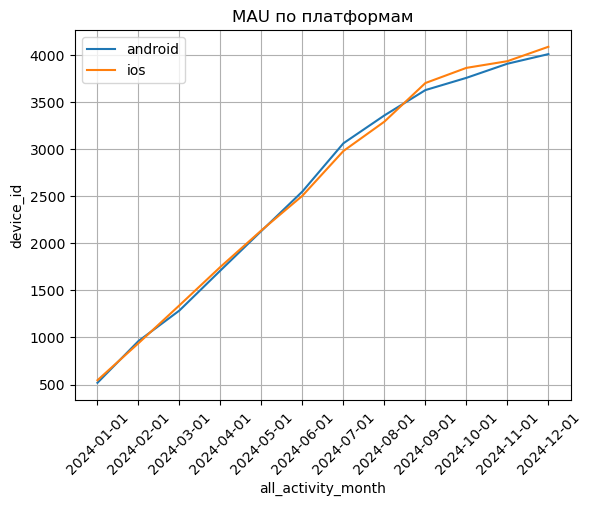

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_dataset.csv')

mau_platforms =df.groupby(['all_activity_month', 'platform'])['device_id'].nunique().reset_index()

for platform in mau_platforms['platform'].unique():
    platform_data = mau_platforms[mau_platforms['platform'] == platform]
    plt.plot(platform_data['all_activity_month'], platform_data['device_id'], label=platform)

plt.title('MAU по платформам')
plt.xlabel('all_activity_month')
plt.ylabel('device_id')
plt.legend()  # Используем label из plt.plot
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Общий MAU по платформам:** Динамика MAU для Android и iOS платформ в целом повторяет тренд, наблюдаемый для общего MAU по всем пользователям. Оба графика демонстрируют рост, за которым следует замедление.

**Вывод:** Ежемесячно активные пользователи (MAU) на платформах Android и iOS следуют общей тенденции роста с последующим замедлением. Поскольку динамика обеих платформ схожа, замедление роста MAU, вероятно, не связано с какими-либо проблемами конкретно Android или iOS.


**2.2 Количество новых пользователей по каналам привлечения.**



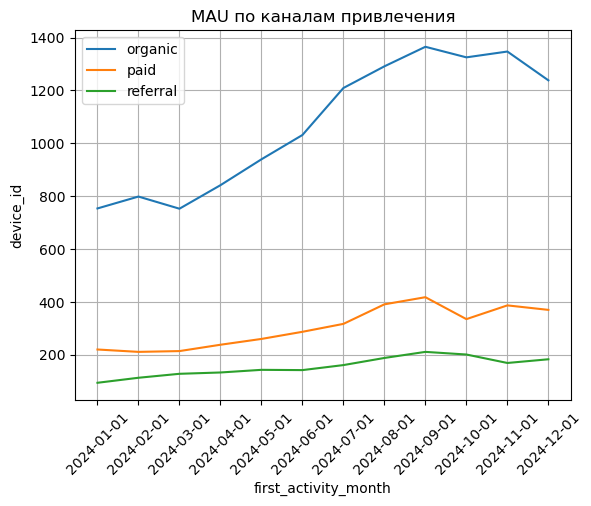

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_dataset.csv')

new_users =df.groupby(['first_activity_month', 'traffic_type'])['device_id'].nunique().reset_index()

for traffic_type in new_users['traffic_type'].unique():
    traffic_type_data = new_users[new_users['traffic_type'] == traffic_type]
    plt.plot(traffic_type_data['first_activity_month'], traffic_type_data['device_id'], label=traffic_type)

plt.title('MAU по каналам привлечения')
plt.xlabel('first_activity_month')
plt.ylabel('device_id')
plt.legend()  # Используем label из plt.plot
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Рост и последующее снижение Organic: Канал Organic демонстрировал устойчивый рост до июля 2024 года, после чего наблюдается замедление темпа роста и последующее снижение.

Paid и Referral - меньший вклад, восходящий тренд: Каналы Paid и Referral привлекают меньше пользователей по сравнению с Organic, но демонстрируют восходящий тренд, указывая на потенциал для дальнейшего развития.

**Вывод:** Основным каналом привлечения пользователей является органический трафик (Organic), однако после июля 2024 года наблюдается его снижение, что может указывать на проблемы с удержанием пользователей или изменения в поисковых алгоритмах. Каналы платной рекламы (Paid) и реферальные программы (Referral) показывают меньший вклад, но демонстрируют положительный тренд и имеют потенциал для роста.


**2.3 Retention Rate по когортам.**

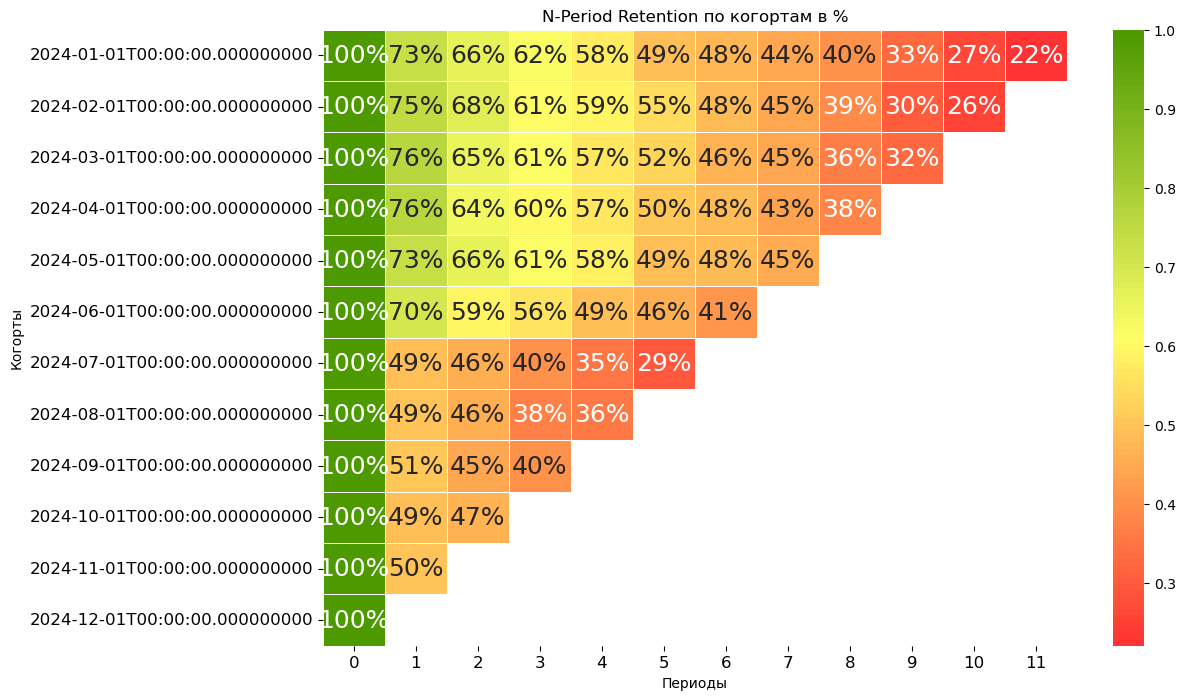

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_dataset.csv')

cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

df['all_activity_month'] = pd.to_datetime(df['all_activity_month'])
df['first_activity_month'] = pd.to_datetime(df['first_activity_month'])

df['n_period'] = (df['all_activity_month'].dt.to_period('M').astype('int64')
                   - df['first_activity_month'].dt.to_period('M').astype('int64'))
data_pivot = pd.pivot_table(df,
                            values='device_id',
                            index='first_activity_month',
                            columns='n_period',
                            aggfunc=pd.Series.nunique)
data_pivot = data_pivot.div(data_pivot[0], axis=0)
df['first_activity_month'] = df['first_activity_month'].dt.date
plt.subplots(figsize=(12, 8))
sns.heatmap(data_pivot,
            cmap=cmap,
            annot=True,
            fmt='.0%',
            linewidth=0.5,
            annot_kws={"size": 18})
plt.title('N-Period Retention по когортам в %')
plt.xlabel('Периоды')
plt.ylabel('Когорты')
plt.yticks(rotation=0)
plt.tick_params(labelsize=12)
plt.show()


**Общий тренд:** Метрика Retention Rate демонстрирует ухудшение для поздних когорт, в особенности для когорты, привлеченной в июле 2024 года. Это означает, что пользователи, привлеченные в июле 2024 года, менее склонны возвращаться и продолжать пользоваться продуктом в последующие месяцы, по сравнению с когортами, привлеченными ранее.

**Вывод:** удержания (Retention Rate) снижается у новых когорт пользователей, особенно у тех, кто присоединился в июле 2024 года. Это указывает на то, что пользователи, привлеченные в июле, возвращаются к продукту реже, чем предыдущие когорты.


**2.4 Доля пройденных уровней на сессию**


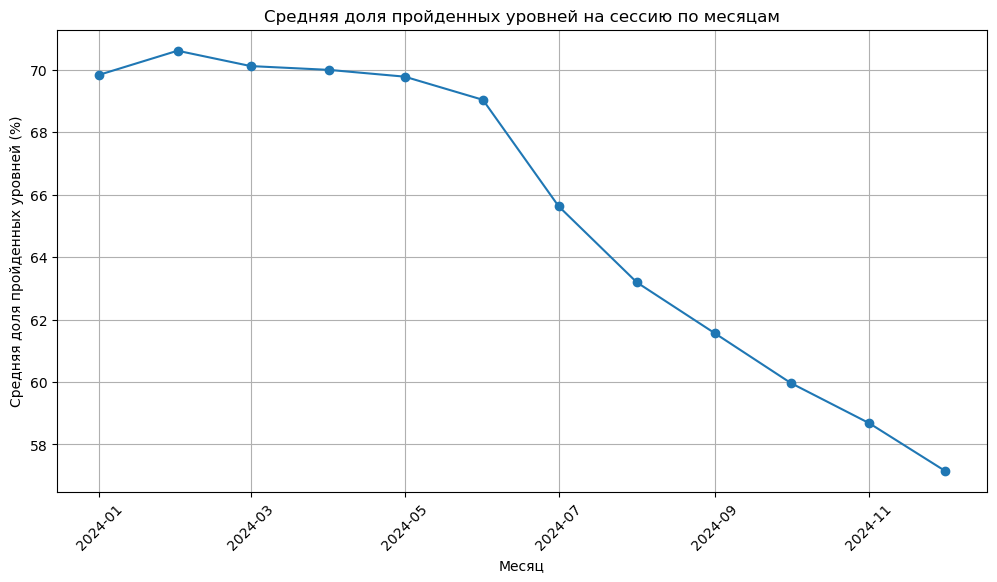

In [4]:
import matplotlib.pyplot as plt

df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_game_sessions.csv')

df['dt'] = pd.to_datetime(df['time_end']).dt.to_period('M').dt.to_timestamp()

df_grouped = df.groupby(['dt', 'device_id', 'session_id']).agg(
    success=('success_fact', 'sum'),
    total=('success_fact', 'count')).reset_index()

df_grouped['success_rate'] = 100 * df_grouped['success'] / df_grouped['total']

df_grouped = df_grouped.groupby('dt')['success_rate'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_grouped['dt'], df_grouped['success_rate'], marker='o')
plt.title('Средняя доля пройденных уровней на сессию по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя доля пройденных уровней (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Общий тренд:** График демонстрирует восходящий тренд средней доли пройденных уровней на сессию в период до июня 2024года. Затем наблюдается резкое снижение этого показателя. Это свидетельствует о том, что пользователи стали проходить меньше уровней за сессию после внедрения изменений.

**Вывод:** Средняя доля пройденных уровней на сессию росла до июня 2024 года, после чего резко снизилась. Это ухудшение вовлеченности пользователей совпадает по времени с редизайном внутриигрового магазина и изменениями в алгоритме генерации уровней, что указывает на вероятную взаимосвязь между этими событиями.


## Вторая часть расчётов и визуализаций

В этой части проекта вы рассчитаем и визуализируем:  
- Среднюю выручку (средний доход) на активного пользователя — ARPAU.
- Воронку конверсии от запуска приложения до покупки во внутриигровом магазине.
- Средний чек и производные от него: среднее количество предметов в заказе и среднюю цену предметов в заказе.
- Долю пользователей, у которых пройдено более 10 уровней.

**3.1 Средняя выручка (средний доход) на активного пользователя — ARPAU**

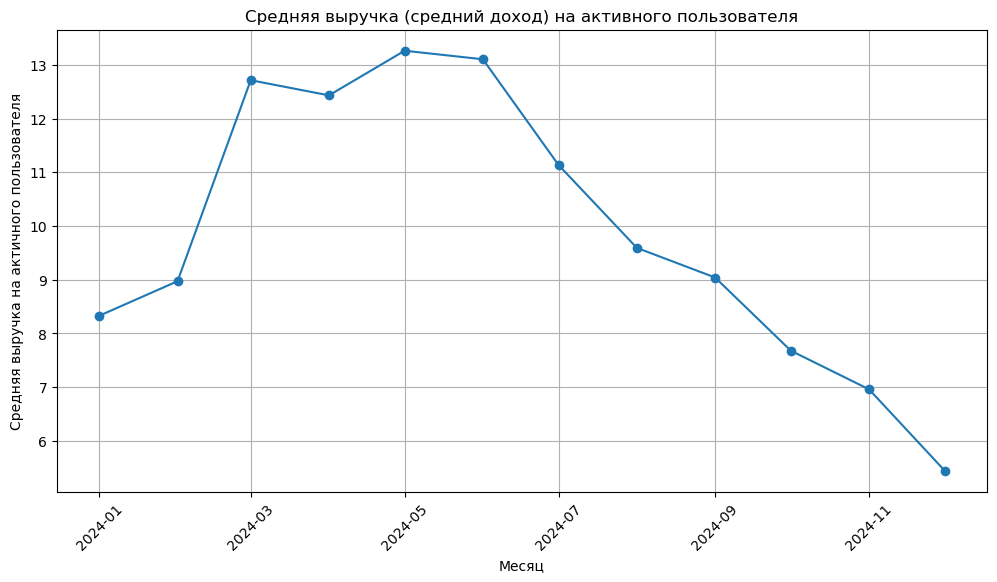

In [6]:
transactions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_transactions.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_events.csv')

transactions['dt'] = pd.to_datetime(transactions['time']).dt.to_period('M').dt.to_timestamp()
events['dt'] = pd.to_datetime(events['time']).dt.to_period('M').dt.to_timestamp()

# Фильтруем успешные транзакции
success_transactions = transactions[transactions['status'] == 'success']

# Рассчитываем сумму стоимостей успешных покупок по месяцам
transactions_sum = success_transactions.groupby('dt')['price'].sum()

# Рассчитываем количество уникальных пользователей по месяцам (из таблицы events)
users_n = events.groupby('dt')['device_id'].nunique()

# Объединяем данные о транзакциях и пользователях
merged_df = pd.merge(transactions_sum, users_n, on='dt', how='inner').reset_index()

# Заполняем пропущенные значения нулями
merged_df = merged_df.fillna(0)

# Рассчитываем ARPU (Average Revenue Per User)
merged_df['ARPAU'] = merged_df['price'] / merged_df['device_id']

plt.figure(figsize=(12, 6))
plt.plot(merged_df['dt'], merged_df['ARPAU'], marker='o')
plt.title('Средняя выручка (средний доход) на активного пользователя')
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка на актичного пользователя')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Общий тренд:** На графике среднего дохода с активного пользователя (ARPAU) зафиксирован заметный спад, начиная с июля. Снижение ARPU подтверждает негативное влияние на общую прибыльность. Снижение ARPU говорит о том, что пользователи, которые ранее совершали покупки, стали делать это реже или стали тратить меньше средств на каждую покупку.

**Вывод:** Средний доход с активного пользователя (ARPU) существенно снизился, начиная с июля, что негативно повлияло на общую прибыльность. Это указывает на то, что пользователи стали реже совершать покупки или тратить меньше средств на каждую транзакцию.



**3.2 Воронку конверсии от запуска приложения до покупки во внутриигровом магазине.**

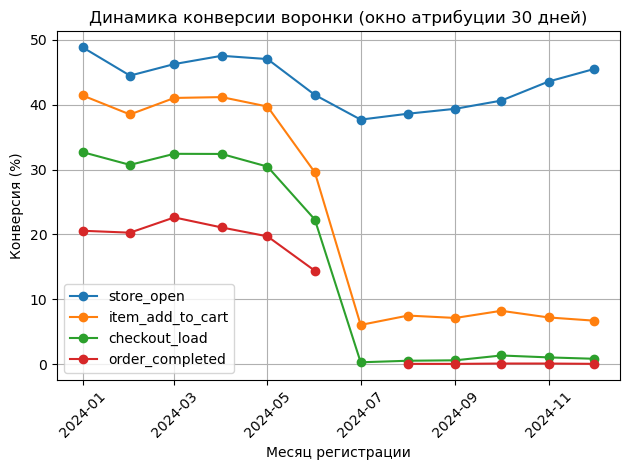

In [8]:
events = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_events.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_users.csv')

events['time'] = pd.to_datetime(events['time'])
users['install_time'] = pd.to_datetime(users['install_time'])
df = pd.merge(events, users[['device_id','install_time']], on='device_id',how='left')
attribution_window = 30
df['diff_days'] =(df['time'] - df['install_time']).dt.days
df = df[df['diff_days'].between(0, attribution_window)]
df['install_month'] =df['install_time'].dt.to_period('M').dt.to_timestamp()

event_list = ["store_open","item_add_to_cart","checkout_load","order_completed"]
funnel_dynamic = df.groupby('install_month')['device_id'].nunique().reset_index(name='install_devices')
for event in event_list:
    df_event = df[df['event_name'] == event]
    df_event = df_event.groupby('install_month')['device_id'].nunique().reset_index(name=event)
    funnel_dynamic = funnel_dynamic.merge(df_event, on='install_month', how='left')
    funnel_dynamic[event] = (funnel_dynamic[event] / funnel_dynamic['install_devices']) * 100
    # Добавляем линию на график
    plt.plot(funnel_dynamic['install_month'], funnel_dynamic[event], marker='o', label=event)

# Оформление графика
plt.title('Динамика конверсии воронки (окно атрибуции 30 дней)')
plt.xlabel('Месяц регистрации')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**store_open (Открытие магазина):** Конверсия на данном этапе демонстрирует стабильные значения с незначительным спадом в июле, который, однако, быстро компенсируется в последующие месяцы. Это говорит об отсутствии серьезных проблем с привлечением пользователей в магазин.

**item_add_to_cart (Добавление в корзину):** Конверсия на этом этапе резко снижается в июле и остается на низком уровне в последующие месяцы. Снижение конверсии на данном этапе указывает на потенциальную проблему со стимулированием пользователей к добавлению товаров в корзину. Возможные причины: изменение ассортимента, технические проблемы на сайте/в приложении, изменение предложения.

**checkout_load (Открытие чекаута):** Динамика конверсии на данном этапе повторяет тенденцию предыдущего этапа – резкое снижение в июле и почти полное отсутствие добавлений в корзину в последующие месяцы. Это является прямым следствием низких показателей добавления товаров в корзину.

**order_completed (Завершение заказа):** Завершение заказа практически отсутствует с июля, что является логичным следствием проблем на предыдущих этапах воронки.

**Вывод:** По графику видно существенное ухудшение показателей конверсии воронки покупок начиная с июля. Основная проблема сосредоточена на этапах добавления товара в корзину и открытия чекаута, что в конечном итоге приводит к значительному снижению количества завершенных заказов.


**3.3 Средний чек и производные от него: среднее количество предметов в заказе и среднюю цену предметов в заказе.**

Средняя цена предметов в заказе за период = Сумма цен всех предметов в заказах за период / Общее количество предметов в заказах за период

C:\Temp\ipykernel_12424\676564467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_transactions['month'] =  pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()


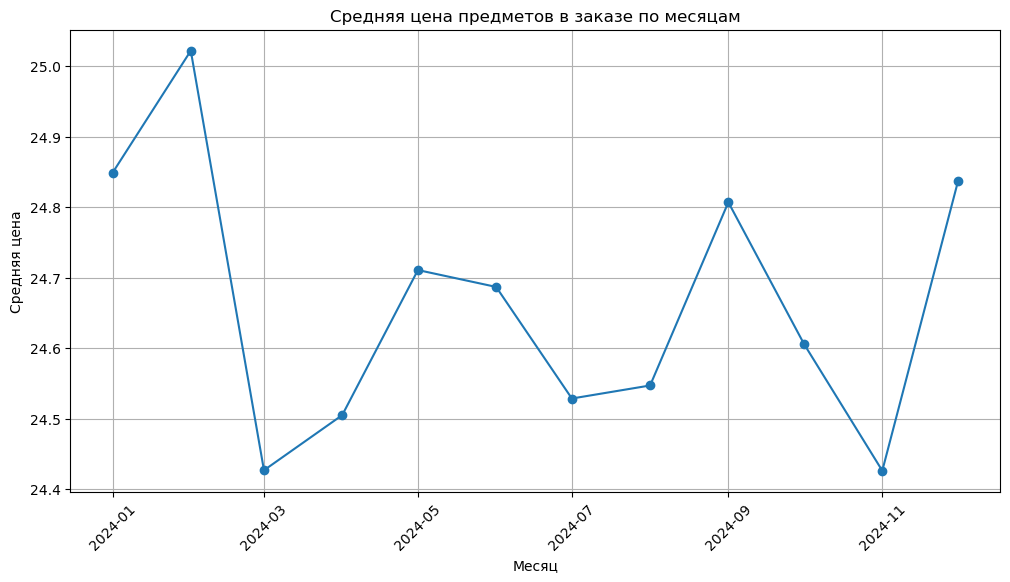

In [9]:
transactions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_transactions.csv')

success_transactions = transactions[transactions['status'] == 'success']
success_transactions['month'] =  pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()
                                               
grouped_transactions = success_transactions.groupby('month').agg(price_sum=('price', 'sum'),item_quantity=('transaction_id', 'count')).reset_index()

grouped_transactions['avg_item_price'] = grouped_transactions['price_sum'] / grouped_transactions['item_quantity']

plt.figure(figsize=(12, 6))
plt.plot(grouped_transactions['month'], grouped_transactions['avg_item_price'], marker='o')
plt.title('Средняя цена предметов в заказе по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Общий тренд:** В начале периода, примерно в марте 2024 года, наблюдается резкое падение средней цены предметов в заказе, приблизительно на 0.5 пунктов. После этого падения график демонстрирует волнообразную динамику, характеризующуюся последовательными периодами роста и снижения. Несмотря на эти колебания, общий уровень средней цены предметов в заказе остается относительно стабильным на протяжении всего рассматриваемого периода. Можно сказать, что тренд является горизонтальным, с небольшими локальными отклонениями вверх и вниз.С ноября видет рост цены.

**Вывод:** Изменение в выручке скорее всего не связано со средней ценой товаров.



Среднее количество предметов в заказе за период = Общее количество предметов, которые были в заказах за период / Количество заказов за период

C:\Temp\ipykernel_12424\3759150553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_transactions['month'] =pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()


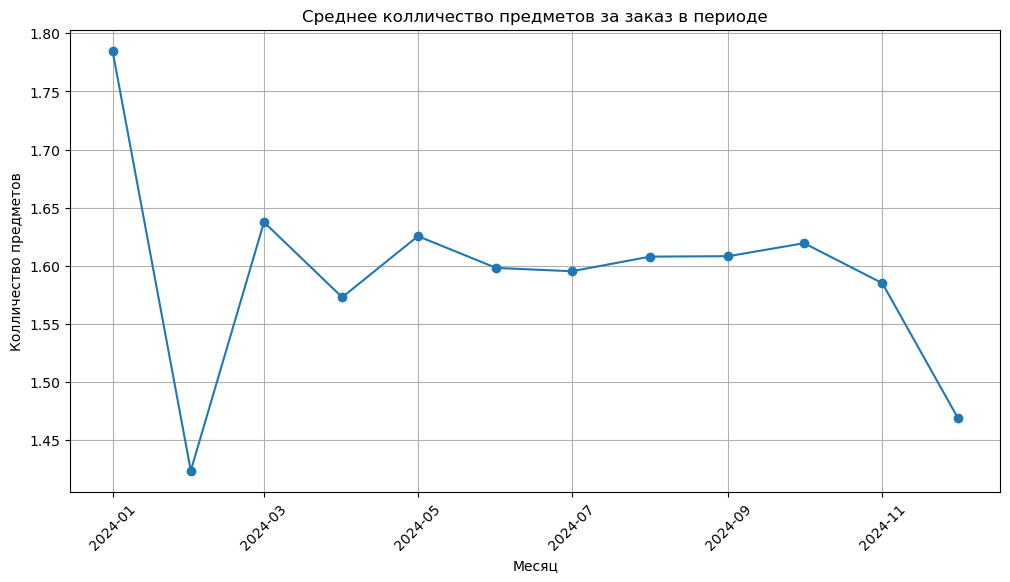

In [10]:
success_transactions =transactions[transactions['status'] == 'success']
success_transactions['month'] =pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp() 
grouped_transactions =success_transactions.groupby('month').agg(order_quantity=('transaction_id', 'nunique'),item_quantity=('transaction_id', 'count')).reset_index()


grouped_transactions['avg_item_count'] =grouped_transactions['item_quantity'] / grouped_transactions['order_quantity']

plt.figure(figsize=(12, 6))
plt.plot(grouped_transactions['month'], grouped_transactions['avg_item_count'], marker='o')
plt.title('Среднее колличество предметов за заказ в периоде')
plt.xlabel('Месяц')
plt.ylabel('Колличество предметов')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**Описание тренда:**
На графике среднего количества предметов в заказе наблюдается снижение примерно в период с февраля по март. После этого снижения, в период с марта по октябрь, показатель стабилизируется и остается относительно постоянным. Начиная с октября, отмечается тенденция к снижению среднего количества предметов в заказе.

**Вывод:** как варинат на это могло повлиять: сезонность, возможно, после новогодних и рождественских праздников, когда покупатели обычно приобретают больше товаров, спрос снижается, и, как следствие, уменьшается среднее количество товаров в одном заказе, экономические факторы, общие экономические условия могли повлиять на покупательскую способность, заставив клиентов сократить количество приобретаемых товаров.


Средний чек = Средняя цена предметов в заказе за период × Среднее количество предметов в заказе за период

C:\Temp\ipykernel_12424\2864980568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_transactions['month'] =pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()


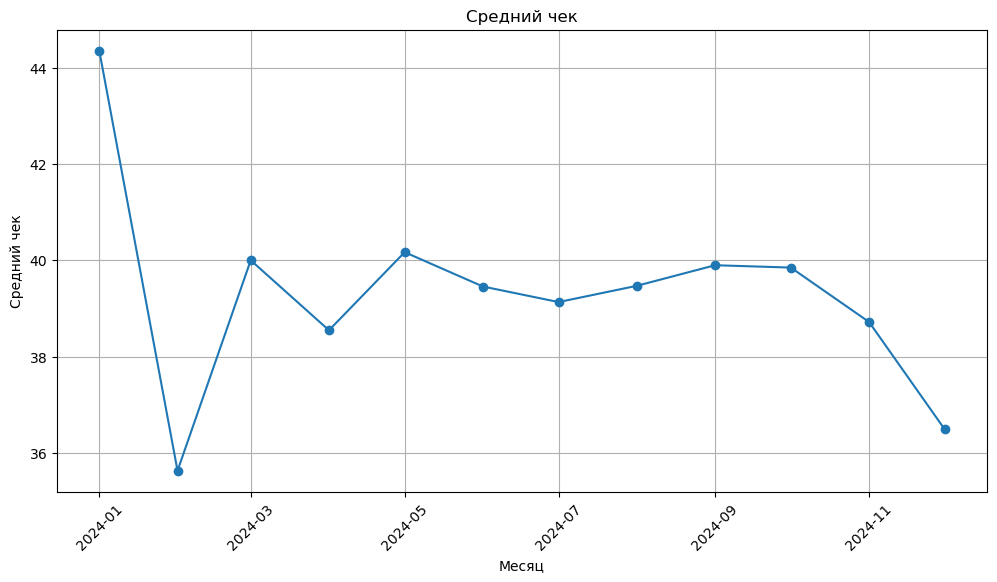

In [11]:
transactions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_transactions.csv')

success_transactions =transactions[transactions['status'] == 'success'] 
success_transactions['month'] =pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp() 

grouped_transactions = success_transactions.groupby('month').agg(
   order_quantity=('transaction_id', 'nunique'),
   item_quantity=('transaction_id', 'count'),
   price_sum=('price','sum')
).reset_index()

grouped_transactions['avg_item_count'] =grouped_transactions['item_quantity'] / grouped_transactions['order_quantity']
grouped_transactions['avg_item_price'] =grouped_transactions['price_sum'] / grouped_transactions['item_quantity']
grouped_transactions['AOV'] =grouped_transactions['avg_item_price']*grouped_transactions['avg_item_count']


plt.figure(figsize=(12, 6))
plt.plot(grouped_transactions['month'], grouped_transactions['AOV'], marker='o')
plt.title('Средний чек')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**Описание тренда:**
На графике среднего чека наблюдается снижение в период с февраля по март. После этого снижения, в период с марта по октябрь, показатель стабилизируется и остается относительно постоянным. Начиная с октября, отмечается тенденция к снижению среднего чека.

**Вывод:** Увеличение цены с ноября, уменьшение количества товаров в заказе повлияли на средний чек, который имеет тенденцию к снижению с ноября месяца 2024 года.


**3.4 Доля пользователей, у которых пройдено более 10 уровней.**

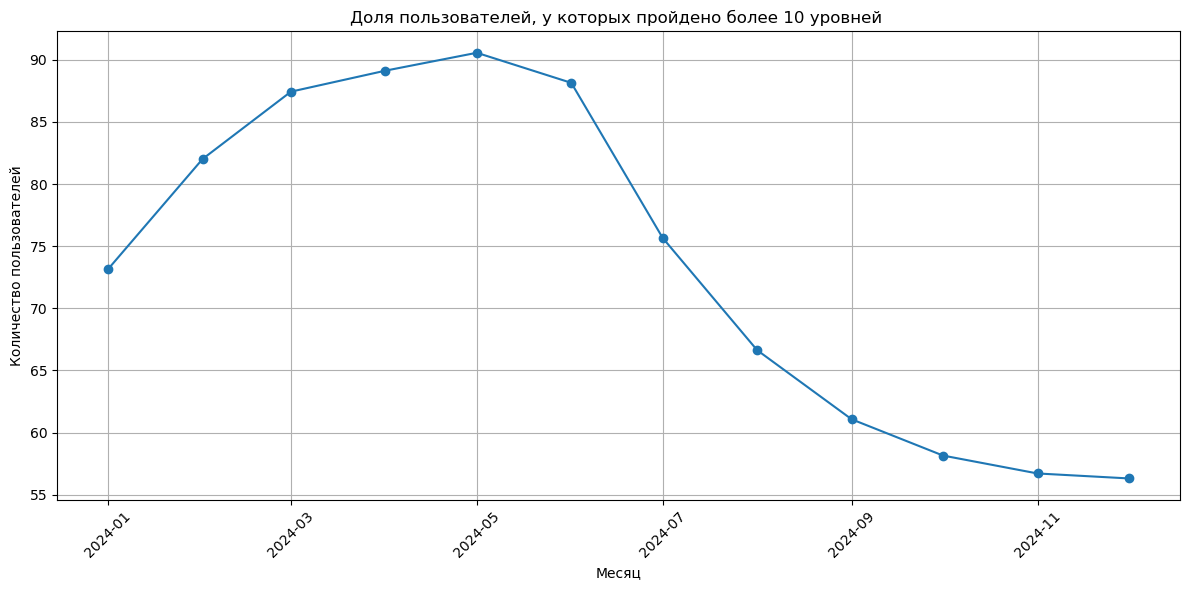

In [12]:
game_sessions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_game_sessions.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_users.csv')

game_sessions['month'] = pd.to_datetime(game_sessions['time_end']).dt.to_period('M').dt.to_timestamp()
users['month'] = pd.to_datetime(users['install_time']).dt.to_period('M').dt.to_timestamp()

df_levels=game_sessions[(game_sessions['level_id'] == 11) & (game_sessions['success_fact'] == 1)] 
df_levels_grouped = df_levels.groupby('month')['device_id'].nunique().reset_index()
df_levels_grouped['cumsum_users_level_success'] =df_levels_grouped['device_id'].cumsum()

df_users_grouped = users.groupby('month')['device_id'].nunique().reset_index()
df_users_grouped['cumsum_users_all'] =df_users_grouped['device_id'].cumsum() 

table_final = pd.merge(df_levels_grouped, df_users_grouped, on='month', how='inner')
table_final['levels_finish_rate'] = round(100 * (table_final['cumsum_users_level_success'] / table_final['cumsum_users_all']), 2)

plt.figure(figsize=(12, 6))
plt.plot(table_final['month'], table_final['levels_finish_rate'], marker='o')
plt.title('Доля пользователей, у которых пройдено более 10 уровней ')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Общий тренд:** С января 2024 года график имеет восходящую динамику, пик в мае 2025 года-чуть более 90% пользователей проходят 10 уровней и более. А с мая доля пользователей, которые прошли 10 уровней и больше начала снижаться, а с июля мы видим резкий спад, почти половина пользователей 55%, не может дойти до 10 уровня к октябрю 2024 года.

**Вывод:** Корректировка алгоритма, который генерирует уровни, котрая произошла летом повлияла на прохождение уровней и ухудшению пользовательского опыта.


## Вывод

- 1.	Наблюдается рост аудитории сервиса, но темп роста MAU (ежемесячно активных пользователей) замедлился после июня 2024 года.
- 2.	Тенденции роста MAU на платформах Android и iOS схожи, что указывает на общую причину замедления роста.
- 3.	Основным каналом привлечения пользователей является органический трафик (Organic), но после июля 2024 года наблюдается его снижение.
- 4.	Снижение показателя удержания (Retention Rate) у новых когорт пользователей, особенно у тех, кто присоединился в июле 2024 года, указывает на проблемы с удержанием аудитории.
- 6.	Снижение среднего дохода с активного пользователя (ARPU) с июля негативно влияет на прибыльность.
- 7.	Ухудшение показателей конверсии воронки покупок начиная с июля.
- 8.	Увеличение цены и уменьшение количества товаров в заказе повлияли на средний чек, который имеет тенденцию к снижению с ноября месяца 2024 года.

 Возможные причины снижения ключевой метрики:
- 1.	Редизайн внутриигрового магазина мог вызвать проблемы с навигацией и поиском товаров, что привело к снижению вовлечённости и конверсии.
- 2.	Изменения в алгоритме генерации уровней могли сделать уровни менее интересными или сложными для прохождения, что также снизило вовлечённость.
- 3.	Снижение органического трафика может быть связано с изменениями в поисковых алгоритмах или снижением качества контента.
- 4.	Уменьшение количества завершённых заказов может быть связано с техническими проблемами на этапах добавления товара в корзину и открытия чекаута.
- 5.	Снижение ARPU может быть связано с уменьшением количества активных пользователей или изменением их поведения.
- 6.	Снижение доли пройденных уровней может быть связано с потерей интереса пользователей к сервису или появлением более привлекательных альтернатив.
